In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [3]:
from typing import Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt
import rasterio.features

from shapely.geometry import Polygon
from shapely.affinity import affine_transform

from msi_zarr_analysis.ml.dataset.translate_annotation import (
    TemplateTransform,
    MatchingResult,
    translate_geometry,
    match_template_multiscale,
)

In [4]:
def auto_crop(img_rgb) -> Tuple[slice, slice]:
    y, x = img_rgb.any(axis=2).nonzero()
    y_slice = slice(0, img_rgb.shape[0])
    x_slice = slice(0, img_rgb.shape[1])
    try:
        y_slice = slice(y.min(), y.max()+1)
    except ValueError:
        pass
    try:
        x_slice = slice(x.min(), x.max()+1)
    except ValueError:
        pass
    return y_slice, x_slice

In [5]:
# create an empty image
template_ = np.zeros((300, 600, 3), dtype=np.uint8)

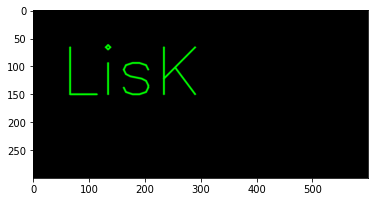

In [6]:
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(template_,'LisK', (50, 150), font, 4, (0,255,0), 2, cv2.LINE_AA)

plt.imshow(template_)

In [7]:
y, x = 83, 157 # these must be ints, lower than 500
scale = 3.85709 # this must be a float, > 0.0
template_transform = TemplateTransform(rotate_90=1, flip_lr=True, flip_ud=False)
crop_idx = auto_crop(template_)
template = template_[crop_idx]

In [8]:
transformed_template = template_transform.transform_template(template)

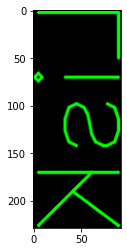

In [9]:
plt.imshow(transformed_template)

In [10]:
resized = cv2.resize(
    transformed_template,
    dsize=None,
    fx=scale,
    fy=scale,
    interpolation=cv2.INTER_NEAREST
)
resized.shape

(883, 355, 3)

In [11]:
# now put the transformed template in an image
image = np.zeros((
    resized.shape[0] + 500,
    resized.shape[1] + 500,
    3,
), dtype=np.uint8)
image.shape

(1383, 855, 3)

In [12]:
y_slice = slice(y, y + resized.shape[0])
x_slice = slice(x, x + resized.shape[1])
image[y_slice, x_slice, :] = resized

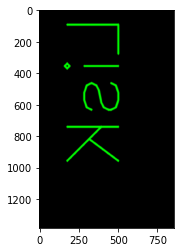

In [13]:
plt.imshow(image)

In [14]:
# perform template matching
matching_result = MatchingResult(scale=scale, y_top_left=y, x_top_left=x, y_slice=y_slice, x_slice=x_slice)
#print(f"{scale=} {y=} {x=} {y_slice=} {x_slice=}")
#matching_result = match_template_multiscale(image, transformed_template)
#matching_result

In [15]:
# now create the annotation : an L on the image above
image_geometry = Polygon([[175, 120], [175, 1000], [350, 1000], [350, 900], [250, 900], [250, 120]])
mask = rasterio.features.rasterize(
    [image_geometry], out_shape=image.shape[:2]
)

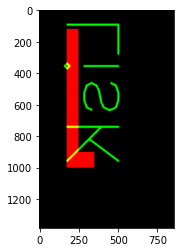

In [16]:
copy = image.copy()
copy[mask>0, 0] = 255
plt.imshow(copy)

array([0, 1], dtype=uint8)

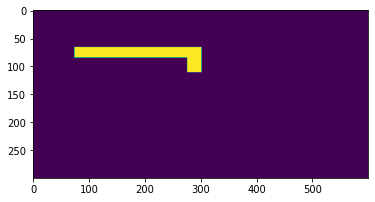

In [17]:
%autoreload

# now translated image_geometry to the template coordinate

transformed = translate_geometry(
    image_geometry,
    template_transform,
    matching_result,
    crop_idx,
)

(minx, miny, maxx, maxy) = transformed.bounds

shape = (int(maxy - min(miny, 0) + 1), int(maxx - min(minx, 0) + 1))

mask = rasterio.features.rasterize(
    [transformed], out_shape=template_.shape[:2]
)

plt.imshow(mask)

np.unique(mask.flatten())

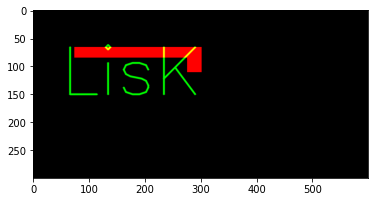

In [18]:
copy = template_.copy()
copy[mask>0, 0] = 255
plt.imshow(copy)